# Initialisation

In [5]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [1]:
import cv2
import os
import sys
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab.patches import cv2_imshow

SILVER_PATH_ARCHIVES = '/content/drive/MyDrive/data/silver/silver'
SILVER_PATH = '/content/data/silver/silver'
NO_SILVER_PATH_ARCHIVES = '/content/drive/MyDrive/data/silver/no_silver'
NO_SILVER_PATH = '/content/data/silver/no_silver'

"""
UPSAMPLED_IMAGES_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/images_upsampled'
UPSAMPLED_IMAGES_PATH = '/content/data/victims/images_upsampled'
UPSAMPLED_TARGETS_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/targets_upsampled'
UPSAMPLED_TARGETS_PATH = '/content/data/victims/targets_upsampled'
"""

MODEL_OUTPUT_PATH = '/content/drive/MyDrive/silver.tflite'

TEST_IMAGES_PATH = '/content/drive/MyDrive/data/silver/test'

os.makedirs(SILVER_PATH, exist_ok=True)
os.makedirs(NO_SILVER_PATH, exist_ok=True)
"""
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)
os.makedirs(UPSAMPLED_IMAGES_PATH, exist_ok=True)
os.makedirs(UPSAMPLED_TARGETS_PATH, exist_ok=True)
"""

def remove_quotation_marks(x):
  return x.replace('"', '').strip()

input_height = 48
input_width = 80

# Unpack data to local runtime


In [3]:
import shutil

for archive in os.listdir(SILVER_PATH_ARCHIVES):
  print(f"Unpacking {archive}...")
  shutil.unpack_archive(SILVER_PATH_ARCHIVES + "/" + archive, extract_dir=SILVER_PATH)

for archive in os.listdir(NO_SILVER_PATH_ARCHIVES):
  print(f"Unpacking {archive}...")
  shutil.unpack_archive(NO_SILVER_PATH_ARCHIVES + "/" + archive, extract_dir=NO_SILVER_PATH)

FileNotFoundError: ignored

# Upsample data

In [ ]:
l = os.listdir(TARGET_OUTPUT_PATH)
c = 0

for filename in l:
  image_path = VICTIMS_PATH + "/" + filename
  has_victims = os.path.isfile(image_path)

  if not has_victims:
    if not os.path.isfile(NO_VICTIMS_PATH + "/" + filename):
      print(f"Target {filename} has no image.")
      continue
    image_path = NO_VICTIMS_PATH + "/" + filename

  target_image = cv2.imread(TARGET_OUTPUT_PATH + "/" + filename, cv2.IMREAD_COLOR)
  cv2.imwrite(UPSAMPLED_TARGETS_PATH + "/" + filename, target_image)

  filename_f = filename[0:-4] + "_f.png"
  # Flip target
  target_flipped = np.flip(target_image, axis=1)
  cv2.imwrite(UPSAMPLED_TARGETS_PATH + "/" + filename_f, target_flipped)

  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  cv2.imwrite(UPSAMPLED_IMAGES_PATH + "/" + filename, image)

  # Flip image
  image_flipped = np.flip(image, axis=1)
  cv2.imwrite(UPSAMPLED_IMAGES_PATH + "/" + filename_f, image_flipped)

  c += 1
  sys.stdout.write(f"Upsampled {c} / {len(l)} images.\r")
  sys.stdout.flush()

# Train and export

Loading images and targets from /content/data/victims/images_upsampled


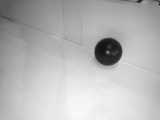

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_34 (Rescaling)    (None, 120, 160, 1)       0         
                                                                 
 conv2d_95 (Conv2D)          (None, 120, 160, 8)       208       
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 15, 20, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 15, 20, 16)        1168      
                                                                 
 dropout_30 (Dropout)        (None, 15, 20, 16)        0         
                                                                 
 flatten_34 (Flatten)        (None, 4800)              0         
                                                     

In [ ]:
# Load images
images = []
targets = []

for filename in os.listdir(SILVER_PATH):
  images.append(cv2.imread(SILVER_PATH + "/" + filename, cv2.IMREAD_GRAYSCALE))
  targets.append(np.array([1.0, 0.0]))

for filename in os.listdir(NO_SILVER_PATH):
  images.append(cv2.imread(NO_SILVER_PATH + "/" + filename, cv2.IMREAD_GRAYSCALE))
  targets.append(np.array([0.0, 1.0]))

# We need to shuffle both arrays in unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return (a[p], b[p])

images = np.array(images)
targets = np.array(targets)

images, targets = unison_shuffled_copies(images, targets)

batch_size = 16

# WORKING MODEL
"""
model = Sequential([
  layers.Rescaling(1./255, input_shape=(input_height, input_width, 1)),
  layers.Conv2D(8, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(2),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(4),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(2),
  layers.Dropout(0.3),
  layers.Flatten(),
  #layers.Dense(1024, activation='linear'),
  layers.Dense(Ys * Xs * Cs, activation='linear'),
  layers.Reshape((Ys, Xs, Cs))
])
"""

# NEW MODEL
model = Sequential([
    layers.Rescaling(1./255, input_shape=(input_height, input_width, 1)),
    layers.Conv2D(4, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(8),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

model.fit(images, targets, batch_size=batch_size, epochs=30, verbose=1)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(MODEL_OUTPUT_PATH, 'wb') as f:
  f.write(tflite_model)

# Test

In [6]:
test_images = []
for img in os.listdir(TEST_IMAGES_PATH):
  image = cv2.imread(TEST_IMAGES_PATH + "/" + img, cv2.IMREAD_GRAYSCALE).astype(np.float32)
  image = np.expand_dims(image, axis=0)
  image = np.expand_dims(image, axis=3)
  test_images.append(image)

interpreter = tf.lite.Interpreter(model_path=MODEL_OUTPUT_PATH)
interpreter.allocate_tensors()

output = interpreter.get_output_details()[0]
input = interpreter.get_input_details()[0]

for image in test_images:
  interpreter.set_tensor(input['index'], image)
  interpreter.invoke()
  out = interpreter.get_tensor(output['index'])
  print(out)

FileNotFoundError: ignored